In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import base64
import requests
import numpy as np
import pandas as pd
import itertools
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
from keras import callbacks
from keras.callbacks import EarlyStopping, CSVLogger
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
INPUT_DIRECTORY = "../dataset"

## Functions define

In [6]:
# It converts categorical data into dummy variables (i.e.one-hot encoding)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


In [7]:
# It encodes categorical values as numerical indexes
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

In [8]:
# It prepares the dataset for TensorFlow by separating the target column (y) 
# from the features (x). If the target is for classification, it performs one-hot encoding; 
# if it's for regression, it leaves it as a continuous value.

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

In [9]:
def load_data():
    filename = "all_attack_sampled_dataset.csv"
    file = os.path.join(INPUT_DIRECTORY,filename)
    df1 = pd.read_csv(file)
    return df1

In [10]:
#  It oversamples the dataset by duplicating minority class rows to balance the dataset
def oversample(dfx):
    max_size = dfx ['SubLabel'].value_counts().max()
    lst = [dfx ]
    for class_index, group in dfx .groupby('SubLabel'):
        lst.append(group.sample(max_size-len(group), replace=True))
    dfx_new = pd.concat(lst)
    return dfx_new

In [11]:
def preprocess(df):
    print("Total number of features : ", len(df.columns))
    print("\n----Dropping features---")
    
    # Drop unnecessary columns
    drop_columns = ['Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Flow ID']
    df.drop(drop_columns, inplace=True, axis=1)
    
    print("Number of features : ", len(df.columns))
    print("\n----Encoding categorical data---")
    
    # General encoding based on broader categories

    # 0: Normal
    df.loc[df['SubLabel'] == 'Normal', 'SubLabel'] = 0

    # 1: DoS attacks
    dos_attacks = ['DOS goldeneye', 'DOS Slowloris', 'ICMP Flood', 'Push ACK Flood', 'SYN FIN Flood', 'UDP Flood']
    df.loc[df['SubLabel'].isin(dos_attacks), 'SubLabel'] = 1

    # 2: Port Scans
    port_scans = ['Port Scan', 'TCP SYN Scan', 'FTP Bounce Scan', 'Host Scan', 'Xmas Scan', 'ACK Scan', 'FIN Scan']
    df.loc[df['SubLabel'].isin(port_scans), 'SubLabel'] = 2

    # 3: Brute Force attacks
    brute_force_attacks = ['SSH BruteForce', 'FTP Bruteforce', 'MySql BruteForce']
    df.loc[df['SubLabel'].isin(brute_force_attacks), 'SubLabel'] = 3

    # 4: Malware
    df.loc[df['SubLabel'] == 'Malware Infiltration', 'SubLabel'] = 4

    # Drop rows where SubLabel is not in [0, 1, 2, 3, 4]
    df = df.drop(df[~df['SubLabel'].isin([0, 1, 2, 3, 4])].index)

    # Replace 'Normal' with 0 and 'Attack' with 1 in 'Label' column (binary classification)
    df.loc[df['Label'] == 'Normal', 'Label'] = 0
    df.loc[df['Label'] == 'Attack', 'Label'] = 1

    # Ensure the data types are correct
    df['SubLabel'] = df['SubLabel'].astype(int)
    df['Label'] = df['Label'].astype(int)


In [12]:
# Funcation for visualization of confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [13]:
# for the evaluation of binary classification model (normal vs. a specific attack), showing similar metrics along with the ROC curve and AUC.
from scipy.interpolate import splrep, splev

def evaluate(y_pred, y_eval, history, Attack_name):
    
    print(f"Accuracy:{accuracy_score(y_eval,y_pred)*100}%")
    print(f"Precison:{precision_score(y_eval,y_pred)*100}")
    print(f"Recall:{recall_score(y_eval,y_pred)*100}")
    print(f"F1-Score:{f1_score(y_eval, y_pred) *100}")
    

    # Plot normalized confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    class_names = ['Normal',Attack_name]
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cm, classes=class_names, normalize=False,title=f'CONFUSION MATRIX \n Normal vs {Attack_name} \n') 
    plt.show()

    # Print ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_eval, y_pred,pos_label=1)
    n = 20
    tck = splrep(fpr, tpr, s=0, k=1)   
    x_interp = np.linspace(0,0.1,n+1)
    y_interp = splev(x_interp, tck)
    plt.figure(figsize=(5,5))
    plt.title(f'ROC CURVE \n {Attack_name} Classification \n')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(x_interp,y_interp)
    plt.show() 

    # Print AUC
    auc = np.trapz(tpr,fpr)
    print('AUC:', auc)
    

# Model Definitions

In [14]:
# This is a binary classification model with one hidden layer (54 units) and softmax output for multiclass classification. 
# It uses early stopping based on validation loss.

def dnnmodel(x,y):
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Training and Testing the model ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    # save model
    # model.save("../model/dnnattack.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_test = np.argmax(y_test,axis=1)
    
    return y_pred ,  y_test, history

## Loading the data

In [15]:
df = load_data()
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,192.168.10.9-110.44.113.201-59647-53-17,192.168.10.9,59647,110.44.113.201,53,17,26/07/2019 12:32:22 PM,63959,0,2,...,0.0,0.0,0,0,0.00,0.00,0,0,Normal,Normal
1,192.168.10.100-8.8.8.8-54856-53-17,192.168.10.100,54856,8.8.8.8,53,17,22/07/2019 02:29:44 PM,103048,0,2,...,0.0,0.0,0,0,0.00,0.00,0,0,Normal,Normal
2,192.168.10.2-192.168.10.6-80-27052-6,192.168.10.6,27052,192.168.10.2,80,6,26/07/2019 03:28:33 PM,34937948,1,1,...,0.0,0.0,0,0,0.00,0.00,0,0,Attack,SYN FIN Flood
3,185.82.212.199-192.168.10.9-80-32860-6,192.168.10.9,32860,185.82.212.199,80,6,26/07/2019 12:26:03 PM,64812032,6,1,...,7087197.0,0.0,7087197,7087197,19241611.67,12893461.09,33406563,8189633,Normal,Normal
4,192.168.10.7-239.255.255.250-0-0-0,192.168.10.7,0,239.255.255.250,0,0,22/07/2019 02:32:46 PM,119825401,6,1,...,0.0,0.0,0,0,23808010.40,15945202.00,48978764,7989707,Normal,Normal


In [16]:
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,70456.000000,70456.000000,70456.000000,7.045600e+04,70456.000000,70456.000000,7.045600e+04,7.045600e+04,70456.000000,70456.000000,...,70456.000000,70456.0,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04
mean,42656.019445,13066.237978,8.899285,1.698287e+07,33.167523,34.191609,2.048875e+04,2.285805e+04,140.938600,7.777336,...,16.831384,0.0,5.205629e+05,1.116933e+05,6.421701e+05,4.409133e+05,6.342716e+06,9.650414e+05,7.228971e+06,5.572509e+06
std,19711.668361,20692.644673,4.909369,3.180906e+07,1080.697703,1047.846169,7.037731e+05,4.622271e+05,411.583824,42.708553,...,445.823474,0.0,2.497573e+06,8.709950e+05,2.887033e+06,2.370201e+06,1.364493e+07,5.194512e+06,1.583098e+07,1.281572e+07
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,37191.250000,68.000000,6.000000,3.469750e+03,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,51413.000000,443.000000,6.000000,4.362390e+05,1.000000,2.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,55885.000000,20031.000000,17.000000,1.132589e+07,3.000000,4.000000,9.600000e+01,1.870000e+02,54.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000496e+06,0.000000e+00,6.000520e+06,5.997663e+06
max,65535.000000,65530.000000,17.000000,1.200000e+08,172161.000000,171867.000000,4.468043e+07,4.455589e+07,20272.000000,1360.000000,...,30825.000000,0.0,1.099361e+08,5.162984e+07,1.099361e+08,1.099361e+08,1.199999e+08,7.402181e+07,1.199999e+08,1.199999e+08


In [17]:
# label distribution
print('Label distribution of data set:')
print(df['SubLabel'].value_counts())


Label distribution of data set:
SubLabel
Normal                  45048
DOS goldeneye            2860
FTP Bruteforce           2708
FTP Bounce Scan          2258
SYN FIN Flood            2156
Host Scan                2107
SSH BruteForce           1991
Port Scan                1966
ACK Scan                 1819
UDP Flood                1382
MySql BruteForce         1373
Push ACK Flood           1311
TCP SYN Scan             1000
Xmas Scan                 997
FIN Scan                  997
Malware Infiltration      449
DOS Slowloris              31
ICMP Flood                  3
Name: count, dtype: int64


## Step 1 : Preprocessing and encoding of data

In [18]:
print("Shape of data:",df.shape)
preprocess(df)
#changing data type
df['Flow Byts/s'] = df['Flow Byts/s'].astype('float32')
df['Flow Pkts/s'] = df['Flow Pkts/s'].astype('float32')
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)

df.head()

Shape of data: (70456, 85)
Total number of features :  85

----Dropping features---
Number of features :  80

----Encoding categorical data---


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,53,17,11159,0,2,0,128,0,0,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,0
1,53,17,90564,0,2,0,116,0,0,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,0
2,80,6,35010346,1,1,0,0,0,0,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,Attack,1
3,443,6,30669622,33,63,2436,72278,1321,0,73.818182,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,0
4,53,6,6845,0,2,0,0,0,0,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,0


In [19]:

df.shape
print(df['SubLabel'].value_counts())

SubLabel
0    44769
2    11144
1     7743
3     6072
4      449
Name: count, dtype: int64


# Now splitting the dataset into category of each and every attack type in the dataset 

In [20]:
df_original = df.copy()
df = oversample(df)
df1=df.copy()
df= df.sample(frac=1).reset_index(drop=True) 
df1= df1.sample(frac=1).reset_index(drop=True)
df1.drop(['Label'], inplace = True , axis=1)
df.drop(['SubLabel'], inplace = True , axis=1)

In [21]:
column_count = df1.shape[1]
print(column_count)


79


In [22]:
print(df1.columns.tolist())


['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'B

In [23]:
print(df.columns.tolist())


['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'B

In [24]:
df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1065,6,52125,0,2,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack
1,4444,6,52,0,2,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack
2,80,6,35403038,1,1,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack
3,4444,6,55,0,2,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack
4,4444,6,17,0,2,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223840,1032,6,1194,0,2,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack
223841,4444,6,54,0,2,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack
223842,4444,6,59,0,2,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack
223843,16898,6,1078,0,2,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Attack


In [25]:
#Scan
df_Scan = df1.drop(df1[(df1.SubLabel!= 2) & (df1.SubLabel!= 0)].index)
#DOS attack
df_DOS = df1.drop(df1[(df1.SubLabel!= 1) & (df1.SubLabel!= 0) ].index)
#BruteForce
df_SSHBruteForce = df1.drop(df1[(df1.SubLabel!= 3) & (df1.SubLabel!= 0) ].index)
#Malware
df_Malware = df1.drop(df1[(df1.SubLabel!= 4) & (df1.SubLabel!= 0) ].index)

In [26]:
df1

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SubLabel
0,4444,6,119997250,9105,4782,37824895,4528,15928,0,4154.299286,...,0,0.0,0.0000,0,0,0.0,0.00,0,0,4
1,15189,17,25300633,3,4,892,349,409,103,297.333333,...,0,615889.0,0.0000,615889,615889,21008701.0,0.00,21008701,21008701,0
2,4444,6,55,0,2,0,0,0,0,0.000000,...,0,0.0,0.0000,0,0,0.0,0.00,0,0,4
3,4444,6,117504757,25382,11500,36727218,4418,4344,0,1446.978883,...,0,0.0,0.0000,0,0,0.0,0.00,0,0,4
4,38984,6,11633,1,2,0,0,0,0,0.000000,...,0,0.0,0.0000,0,0,0.0,0.00,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223840,53,17,111641,0,2,0,113,0,0,0.000000,...,0,0.0,0.0000,0,0,0.0,0.00,0,0,0
223841,4444,6,55,0,2,0,0,0,0,0.000000,...,0,0.0,0.0000,0,0,0.0,0.00,0,0,4
223842,4444,6,117327502,9,13,1037,729,184,0,115.222222,...,0,416835.0,154533.4672,573598,264632,38483871.0,28205880.35,60104159,6578845,4
223843,53,6,2865,0,2,0,0,0,0,0.000000,...,0,0.0,0.0000,0,0,0.0,0.00,0,0,0


In [27]:
print(df1['SubLabel'].value_counts())

SubLabel
4    44769
0    44769
3    44769
2    44769
1    44769
Name: count, dtype: int64


## Step 2: Feature scaling

In [28]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables

X_Scan,Y_Scan = to_xy(df_Scan,'SubLabel')
Y_ScanF = df_Scan.SubLabel

X_DOS,Y_DOS = to_xy(df_DOS,'SubLabel')
Y_DOSF = df_DOS.SubLabel

X_SSHBruteForce,Y_SSHBruteForce = to_xy(df_SSHBruteForce,'SubLabel')
Y_SSHBruteForceF = df_SSHBruteForce.SubLabel

X_Malware,Y_Malware = to_xy(df_Malware,'SubLabel')
Y_MalwareF = df_Malware.SubLabel

### Use StandardScaler() to scale the dataframes

In [29]:
scaler1 = preprocessing.StandardScaler().fit(X_Scan)
X_Scan = scaler1.transform(X_Scan) 

scaler2 = preprocessing.StandardScaler().fit(X_DOS)
X_DOS = scaler2.transform(X_DOS) 

scaler3 = preprocessing.StandardScaler().fit(X_SSHBruteForce)
X_SSHBruteForce = scaler3.transform(X_SSHBruteForce) 

scaler4 = preprocessing.StandardScaler().fit(X_Malware)
X_Malware = scaler4.transform(X_Malware) 



## Step 3: Feature Selection

### 1. Univariate Feature Selection using ANOVA F-test

In [30]:
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
colNames=list(df1)
selector=SelectPercentile(f_classif, percentile=50)



In [31]:
X_newScan = selector.fit_transform(X_Scan,Y_ScanF)
X_newScan.shape

(89538, 39)

#### Get the features that were selected: Port Scan

In [32]:
true=selector.get_support()
newcolindex_Scan=[i for i, x in enumerate(true) if x]
newcolname_Scan=list( colNames[i] for i in newcolindex_Scan )
newcolname_Scan

['Protocol',
 'Flow Duration',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd URG Flags',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'URG Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Bwd Seg Size Avg',
 'Init Bwd Win Byts',
 'Active Mean',
 'Active Max',
 'Active Min',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

In [33]:
X_newDOS = selector.fit_transform(X_DOS,Y_DOSF)
X_newDOS.shape

(89538, 39)

####  Get the features that were selected: DoS

In [34]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS


['Dst Port',
 'Protocol',
 'Flow Duration',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd PSH Flags',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'PSH Flag Cnt',
 'Down/Up Ratio',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Init Bwd Win Byts',
 'Active Mean',
 'Active Min',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

In [35]:
X_newSSHBruteForce = selector.fit_transform(X_SSHBruteForce ,Y_SSHBruteForceF)
X_newSSHBruteForce .shape

(89538, 39)

#### Get the features that were selected: SSHBruteForce 

In [36]:
true=selector.get_support()
newcolindex_SSHBruteForce =[i for i, x in enumerate(true) if x]
newcolname_SSHBruteForce =list( colNames[i] for i in newcolindex_SSHBruteForce  )
newcolname_SSHBruteForce 

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Bwd PSH Flags',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Init Bwd Win Byts',
 'Active Std',
 'Idle Std',
 'Idle Min']

In [37]:
X_newMalware = selector.fit_transform(X_Malware ,Y_MalwareF)
X_newMalware.shape

(89538, 39)

#### Get the features that were selected: Malware

In [38]:
true=selector.get_support()
newcolindex_Malware =[i for i, x in enumerate(true) if x]
newcolname_Malware =list( colNames[i] for i in newcolindex_Malware)
newcolname_Malware

['Dst Port',
 'Protocol',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Min',
 'Fwd IAT Std',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd PSH Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'Down/Up Ratio',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Subflow Fwd Pkts',
 'Subflow Fwd Byts',
 'Subflow Bwd Pkts',
 'Init Bwd Win Byts',
 'Fwd Act Data Pkts',
 'Active Mean',
 'Active Min']

### 3. Selecton of feature

In [39]:
dff = df1.copy()
dff = dff[dff.columns.intersection([
    'ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 
    'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 
    'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd PSH Flags', 'Bwd Pkt Len Max', 
    'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 
    'Bwd Seg Size Avg', 'Bwd URG Flags', 'Down/Up Ratio', 'Dst Port', 
    'FIN Flag Cnt', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 
    'Flow IAT Min', 'Flow IAT Std', 'Fwd Act Data Pkts', 'Fwd Header Len', 
    'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 
    'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 
    'Fwd Pkt Len Std', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 
    'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 
    'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 
    'Protocol', 'PSH Flag Cnt', 'RST Flag Cnt', 'SYN Flag Cnt', 
    'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 
    'Tot Bwd Pkts', 'Tot Fwd Pkts', 'TotLen Fwd Pkts'
])]


dff.head()


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Init Bwd Win Byts,Fwd Act Data Pkts,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,4444,6,119997250,9105,4782,37824895,15928,0,4154.299286,3519.356893,...,15061,9076,0.0,0.0,0,0,0.0,0.0,0,0
1,15189,17,25300633,3,4,892,409,103,297.333333,168.921086,...,-1,3,615889.0,0.0,615889,615889,21008701.0,0.0,21008701,21008701
2,4444,6,55,0,2,0,0,0,0.000000,0.000000,...,0,0,0.0,0.0,0,0,0.0,0.0,0,0
3,4444,6,117504757,25382,11500,36727218,4344,0,1446.978883,60.359256,...,15061,25355,0.0,0.0,0,0,0.0,0.0,0,0
4,38984,6,11633,1,2,0,0,0,0.000000,0.000000,...,262,0,0.0,0.0,0,0,0.0,0.0,0,0


## Step 4: Building the model

### 1. Model trained for all features 

In [40]:
#Fit Dense Neural Network
y_pred_Scan,y_eval_Scan,h_Scan = dnnmodel(X_Scan,Y_Scan)

y_pred_DOS,y_eval_DOS,h_DOS = dnnmodel(X_DOS,Y_DOS)

y_pred_SSHBruteForce,y_eval_SSHBruteForce,h_SSHBruteForce = dnnmodel(X_SSHBruteForce ,Y_SSHBruteForce )

y_pred_Malware,y_eval_Malware,h_Malware = dnnmodel(X_Malware,Y_Malware)


#### Training and Testing the model ####
Epoch 1/1000
1959/1959 - 10s - loss: 0.1700 - val_loss: 0.1321 - 10s/epoch - 5ms/step
Epoch 2/1000
1959/1959 - 7s - loss: 0.1187 - val_loss: 0.1115 - 7s/epoch - 4ms/step
Epoch 3/1000
1959/1959 - 9s - loss: 0.1013 - val_loss: 0.0944 - 9s/epoch - 5ms/step
Epoch 4/1000
1959/1959 - 7s - loss: 0.0916 - val_loss: 0.0891 - 7s/epoch - 3ms/step
Epoch 5/1000
1959/1959 - 6s - loss: 0.0841 - val_loss: 0.0813 - 6s/epoch - 3ms/step
Epoch 6/1000
1959/1959 - 6s - loss: 0.0787 - val_loss: 0.0737 - 6s/epoch - 3ms/step
Epoch 7/1000
1959/1959 - 6s - loss: 0.0739 - val_loss: 0.0745 - 6s/epoch - 3ms/step
Epoch 8/1000
1959/1959 - 11s - loss: 0.0701 - val_loss: 0.0666 - 11s/epoch - 6ms/step
Epoch 9/1000
1959/1959 - 8s - loss: 0.0668 - val_loss: 0.0708 - 8s/epoch - 4ms/step
Epoch 10/1000
1959/1959 - 8s - loss: 0.0634 - val_loss: 0.0659 - 8s/epoch - 4ms/step
Epoch 11/1000
1959/1959 - 11s - loss: 0.0617 - val_loss: 0.0605 - 11s/epoch - 5ms/step
Epoch 12/1000
1959/1959 - 1

### 2. Model is trained for selectedd features

### ANOVA Univariate Feature Selection

In [41]:
#Fit Dense Neural Network

y_pred_newScan,y_eval_newScan,h_newScan = dnnmodel(X_newScan,Y_Scan)

y_pred_newDOS,  y_eval_newDOS,h_newDOS = dnnmodel(X_newDOS,Y_DOS)

y_pred_newSSHBruteForce,y_eval_newSSHBruteForce,h_newSSHBruteForce = dnnmodel(X_newSSHBruteForce ,Y_SSHBruteForce )

y_pred_newMalware,y_eval_newMalware,h_newMalware = dnnmodel(X_newMalware,Y_Malware)

#### Training and Testing the model ####
Epoch 1/1000
1959/1959 - 6s - loss: 0.2481 - val_loss: 0.2318 - 6s/epoch - 3ms/step
Epoch 2/1000
1959/1959 - 5s - loss: 0.2248 - val_loss: 0.2225 - 5s/epoch - 3ms/step
Epoch 3/1000
1959/1959 - 7s - loss: 0.2170 - val_loss: 0.2146 - 7s/epoch - 4ms/step
Epoch 4/1000
1959/1959 - 7s - loss: 0.2116 - val_loss: 0.2083 - 7s/epoch - 3ms/step
Epoch 5/1000
1959/1959 - 8s - loss: 0.2075 - val_loss: 0.2253 - 8s/epoch - 4ms/step
Epoch 6/1000
1959/1959 - 13s - loss: 0.2031 - val_loss: 0.2016 - 13s/epoch - 6ms/step
Epoch 7/1000
1959/1959 - 13s - loss: 0.2011 - val_loss: 0.2066 - 13s/epoch - 7ms/step
Epoch 8/1000
1959/1959 - 11s - loss: 0.1988 - val_loss: 0.1976 - 11s/epoch - 5ms/step
Epoch 9/1000
1959/1959 - 14s - loss: 0.1960 - val_loss: 0.1985 - 14s/epoch - 7ms/step
Epoch 10/1000
1959/1959 - 15s - loss: 0.1951 - val_loss: 0.2001 - 15s/epoch - 8ms/step
Epoch 11/1000
1959/1959 - 12s - loss: 0.1932 - val_loss: 0.1915 - 12s/epoch - 6ms/step
Epoch 12/1000
1959/19

# evalution of Binary individual models 

Evaluation with all features
Accuracy:98.28382101109374%
Precison:99.10337552742617
Recall:97.46572804742497
F1-Score:98.27773004072178
Confusion matrix, without normalization


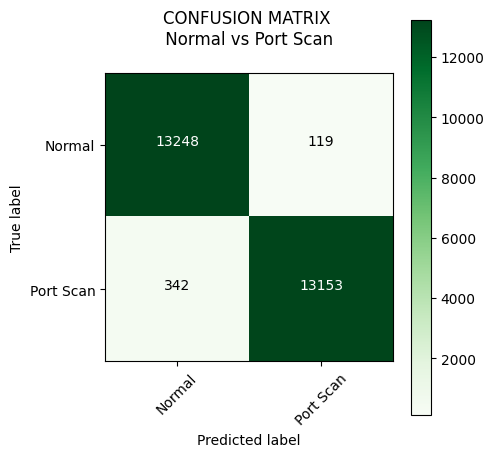

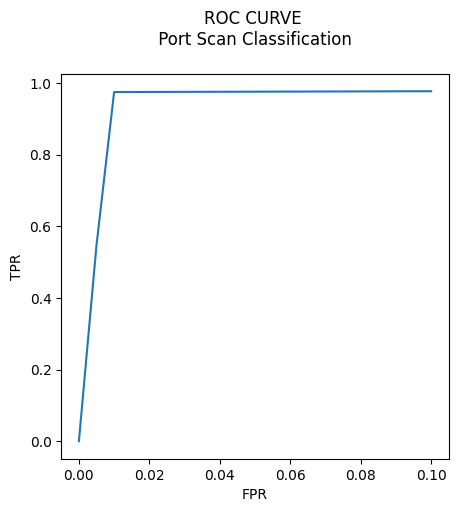

AUC: 0.9828773796700567
Evaluation with selected features using ANOVA
Accuracy:93.87238478147569%
Precison:89.389003390732
Recall:99.62949240459429
F1-Score:94.2318474908887
Confusion matrix, without normalization


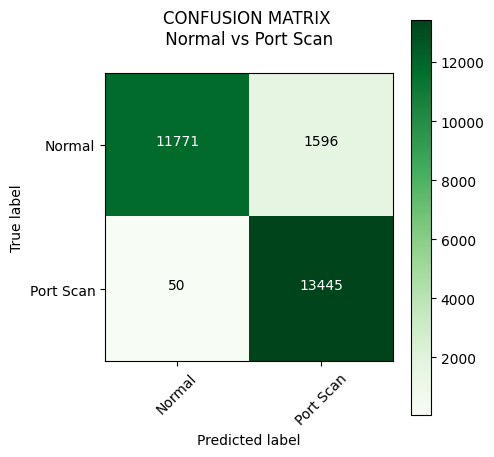

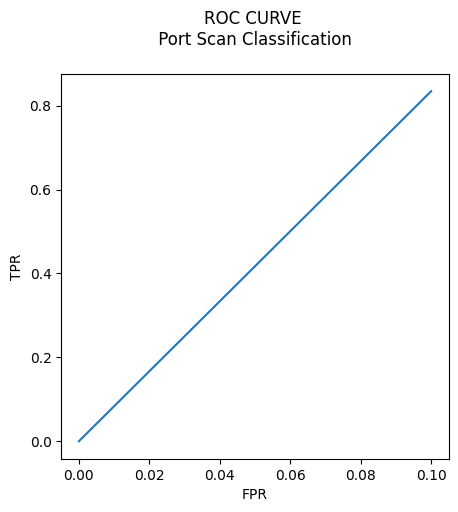

AUC: 0.938448202652881


In [42]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_Scan, y_eval_Scan, h_Scan,'Port Scan' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newScan,y_eval_newScan,h_newScan, 'Port Scan')

Evaluation with all features
Accuracy:99.46020400565855%
Precison:99.4911322307865
Recall:99.42416990726892
F1-Score:99.4576397980176
Confusion matrix, without normalization


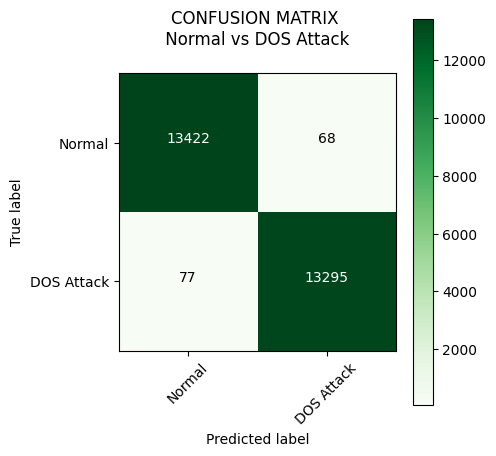

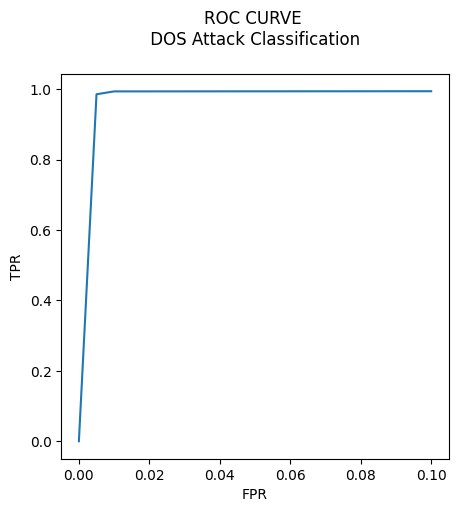

AUC: 0.9946004640656256
Evaluation with selected features using ANOVA
Accuracy:98.92040801131711%
Precison:98.1522379269729
Recall:99.70834579718816
F1-Score:98.92417272592373
Confusion matrix, without normalization


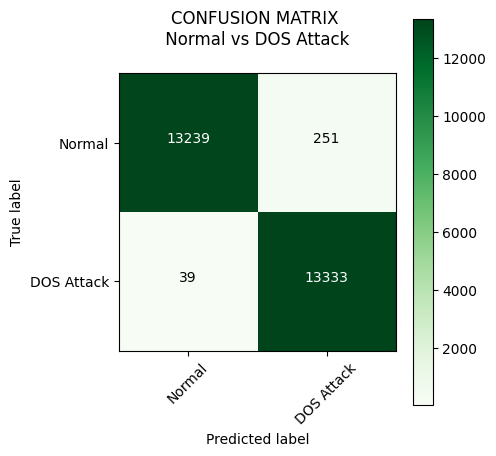

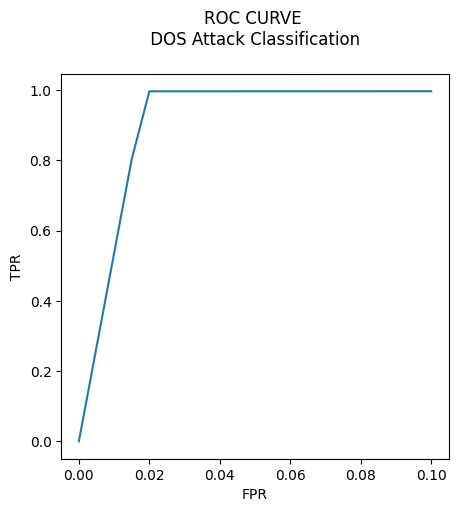

AUC: 0.9892385414396102


In [43]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_DOS, y_eval_DOS, h_DOS, 'DOS Attack' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newDOS,  y_eval_newDOS,h_newDOS, 'DOS Attack')


Evaluation with all features
Accuracy:97.72541136177499%
Precison:96.29817444219067
Recall:99.25334129769283
F1-Score:97.75342868698752
Confusion matrix, without normalization


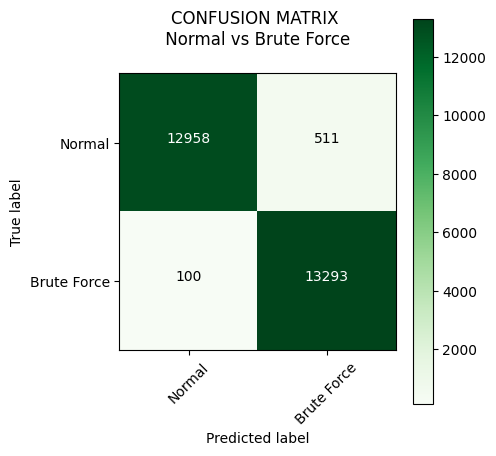

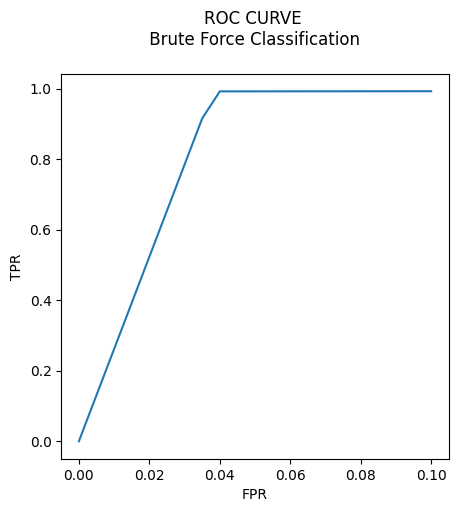

AUC: 0.9772972210032758
Evaluation with selected features using ANOVA
Accuracy:97.099992554538%
Precison:95.74267478967218
Recall:98.56641529157022
F1-Score:97.13402744564218
Confusion matrix, without normalization


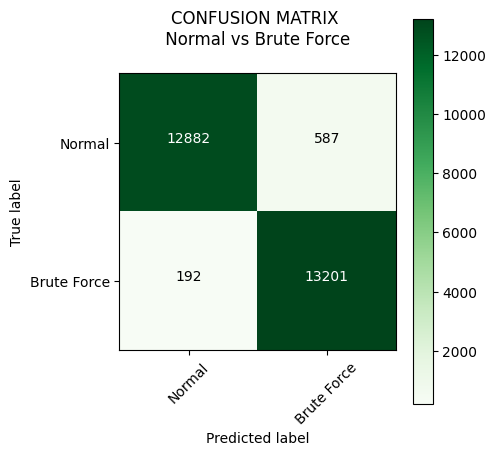

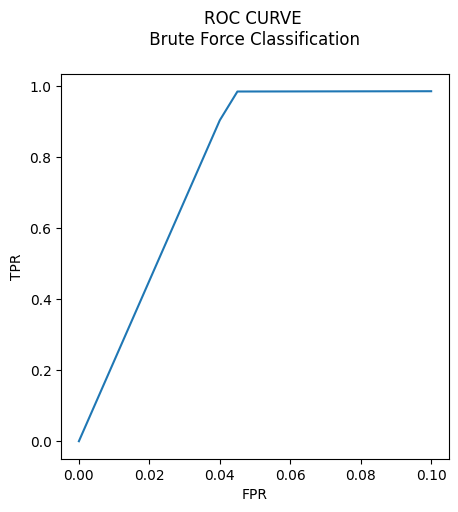

AUC: 0.9710412976324


In [44]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_SSHBruteForce , y_eval_SSHBruteForce , h_SSHBruteForce, 'Brute Force' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newSSHBruteForce,y_eval_newSSHBruteForce,h_newSSHBruteForce , 'Brute Force')


Evaluation with all features
Accuracy:99.59049959049959%
Precison:99.36170212765958
Recall:99.83045849918915
F1-Score:99.59552875422857
Confusion matrix, without normalization


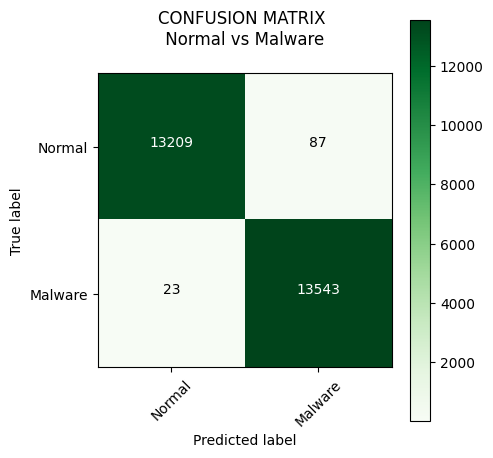

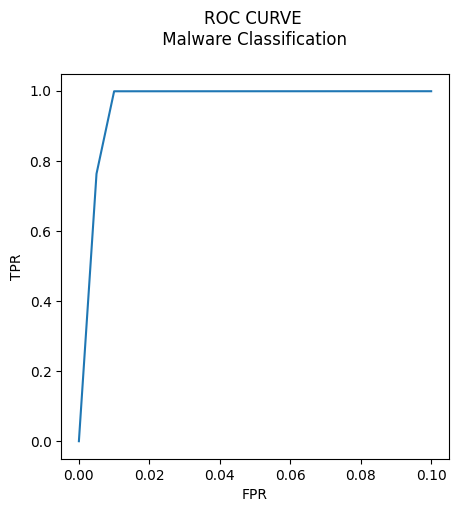

AUC: 0.9958806318461263
Evaluation with selected features using ANOVA
Accuracy:98.87945797036706%
Precison:98.02331474911303
Recall:99.79360165118679
F1-Score:98.90053694707235
Confusion matrix, without normalization


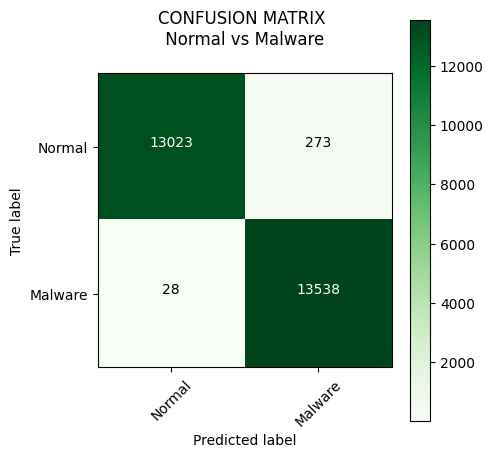

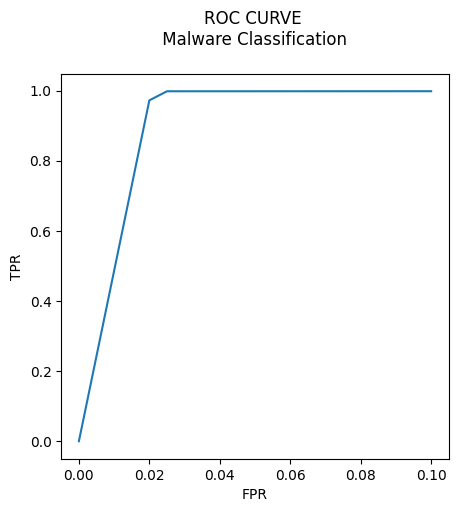

AUC: 0.9887017627685695


In [40]:
print("Evaluation with all features")
evaluate(y_pred_DOS, y_eval_DOS, h_DOS , 'Malware')
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newDOS,  y_eval_newDOS,h_newDOS, 'Malware')

# Now Creating Multiclass Classification model 

In [97]:
def dnnmodel_multiclass():
    x = df1.iloc[:,0:78].values  
    y = df1.iloc[:,78:83].values
    
    #scale using minmaxscalar
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    # Save the scaler to disk
    joblib.dump(scaler, "../model/scaler.save")
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Dense Neural Network ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(x.shape[1], input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
    # model.save("../model/Rids-model.hdf5")
    # print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_eval = np.argmax(y_test,axis=1)
    
    #model summary
    print(model.summary())
    
    return y_pred ,  y_eval, history


In [ ]:
print("With all Features")
y_pred_dnn, y_eval_dnn, h_dnn  = dnnmodel_multiclass()

With all the features
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96     13575
        Scan       1.00      0.99      1.00     13533
         DOS       0.96      0.99      0.98     13353
  Bruteforce       0.97      0.98      0.98     13291
     Malware       1.00      1.00      1.00     13402

    accuracy                           0.98     67154
   macro avg       0.98      0.98      0.98     67154
weighted avg       0.98      0.98      0.98     67154

Accuracy:98.18476933615273%
Confusion matrix, without normalization


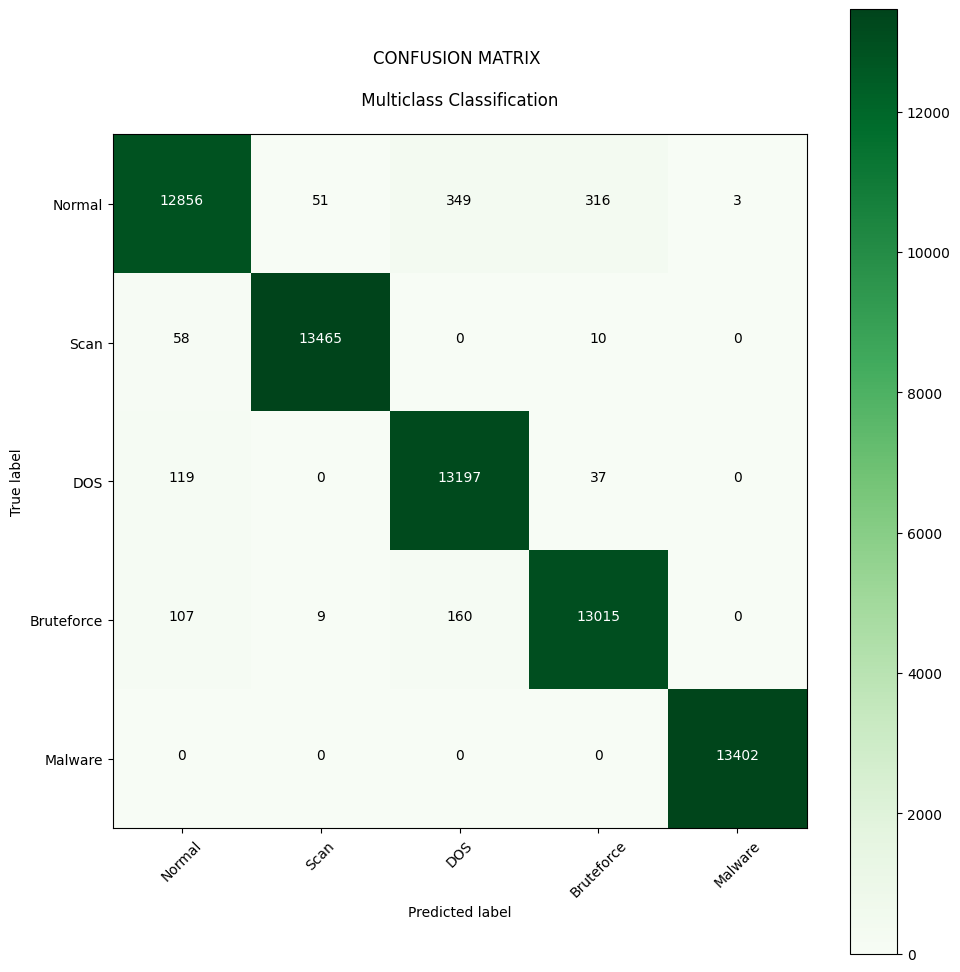

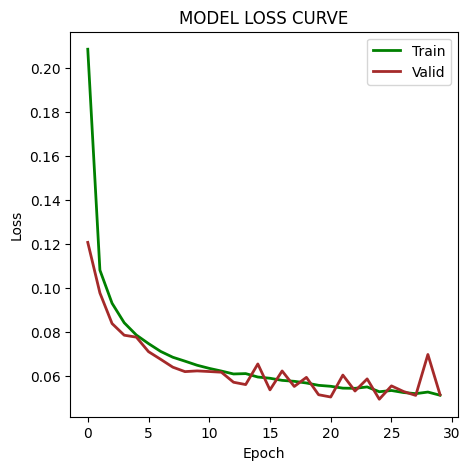

In [75]:
print("With all the features")
evaluate_multiclass(y_pred_dnn, y_eval_dnn, h_dnn )

In [45]:
import joblib
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model("../model/Rids-model.hdf5")

# Load the saved scaler
scaler = joblib.load("../model/scaler.save")

# Example new input data (replace with actual values for all 78 features)
# Example of a normal flow input with 78 features
new_input = [[80,    # Dst Port (Targeted port, often port 80 for HTTP)
               6,     # Protocol (e.g., TCP)
               10000, # Flow Duration (shorter duration, intense flow)
               2000,  # Tot Fwd Pkts (large number of forward packets)
               1000,  # Tot Bwd Pkts
               200000,# TotLen Fwd Pkts (higher total length)
               50000, # TotLen Bwd Pkts
               1000,  # Fwd Pkt Len Max (short packet lengths)
               50,    # Fwd Pkt Len Min
               300,   # Fwd Pkt Len Mean
               200,   # Fwd Pkt Len Std
               800,   # Bwd Pkt Len Max
               100,   # Bwd Pkt Len Min
               300,   # Bwd Pkt Len Mean
               200,   # Bwd Pkt Len Std
               100000000, # Flow Byts/s (high data flow rate)
               200000,    # Flow Pkts/s (high packet rate)
               50,    # Flow IAT Mean (very low inter-arrival times)
               20,    # Flow IAT Std
               100,   # Flow IAT Max
               10,    # Flow IAT Min
               50,    # Fwd IAT Tot
               10,    # Fwd IAT Mean
               5,     # Fwd IAT Std
               50,    # Fwd IAT Max
               1,     # Fwd IAT Min
               20,    # Bwd IAT Tot
               5,     # Bwd IAT Mean
               2,     # Bwd IAT Std
               20,    # Bwd IAT Max
               1,     # Bwd IAT Min
               0,     # Fwd PSH Flags
               0,     # Bwd PSH Flags
               0,     # Fwd URG Flags
               0,     # Bwd URG Flags
               8000,  # Fwd Header Len (high header length)
               2000,  # Bwd Header Len
               5000,  # Fwd Pkts/s (higher forward packet rate)
               2000,  # Bwd Pkts/s
               50,    # Pkt Len Min
               1000,  # Pkt Len Max
               300,   # Pkt Len Mean
               400,   # Pkt Len Std
               0,     # FIN Flag Cnt
               100,   # SYN Flag Cnt (high SYN count in case of SYN flood)
               0,     # RST Flag Cnt
               0,     # PSH Flag Cnt
               50,    # ACK Flag Cnt
               0,     # URG Flag Cnt
               0,     # CWE Flag Count
               0,     # ECE Flag Cnt
               1,     # Down/Up Ratio
               300,   # Pkt Size Avg
               400,   # Fwd Seg Size Avg
               350,   # Bwd Seg Size Avg
               0.1,   # Fwd Byts/b Avg
               100000,   # Fwd Pkts/b Avg
               0.1,   # Fwd Blk Rate Avg
               0.2,   # Bwd Byts/b Avg
               0.15,  # Bwd Pkts/b Avg
               0.3,   # Bwd Blk Rate Avg
               10,    # Subflow Fwd Pkts
               5000,  # Subflow Fwd Byts
               8,     # Subflow Bwd Pkts
               4000,  # Subflow Bwd Byts
               1000,  # Init Fwd Win Byts
               3000,  # Init Bwd Win Byts
               10,    # Fwd Act Data Pkts
               50,    # Fwd Seg Size Min
               20,    # Active Mean (short active times)
               10,    # Active Std
               50,    # Active Max
               10,    # Active Min
               100,   # Idle Mean (low idle time)
               10,    # Idle Std
              100,
               100,   # Idle Max
               10     # Idle Min
               ]]


# Standardize the new input
new_input_scaled = scaler.transform(new_input)

# Predict the class of the new input
predicted_probabilities = model.predict(new_input_scaled)
predicted_class = np.argmax(predicted_probabilities, axis=1)

# Map the predicted class to the attack type
class_labels = ['Normal', 'Scan', 'DOS', 'Bruteforce', 'Malware']
predicted_attack_type = class_labels[predicted_class[0]]

# Output the result
print(f"Predicted Attack Type: {predicted_attack_type}")


1/1 [==============================] - 0s 400ms/step
Predicted Attack Type: DOS


In [46]:
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 78)                6162      
                                                                 
 dense_23 (Dense)            (None, 5)                 395       
                                                                 
Total params: 6,557
Trainable params: 6,557
Non-trainable params: 0
_________________________________________________________________


In [47]:
x = df1.iloc[:, 0:78].values
y = df1.iloc[:,78:83].values


In [49]:
feature_names = df1.columns[:78].tolist()
print("Features used in the model:", feature_names)


Features used in the model: ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rat

In [50]:
label_names = df1.columns[78:83].tolist()
print("Labels used in the model:", label_names)


Labels used in the model: ['SubLabel']


In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib

# List of required features (must match exactly with what the model expects)
required_features = [
    'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
    'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
    'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
    'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
    'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
    'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
    'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
    'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
    'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
    'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
    'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
    'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts',
    'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
    'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
    'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
]

class_labels = ['Normal', 'Scan', 'DOS', 'Bruteforce', 'Malware']
csv_path = "C:/Users/linpa/OneDrive/Desktop/Final_/test_dataset/test_d.csv"  # ← Replace with your CSV path
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
    exit()

# Check for required columns
missing_features = [feat for feat in required_features if feat not in df.columns]
if missing_features:
    print(f"Missing required features: {missing_features}")
    exit()

if 'Timestamp' not in df.columns:
    print("Error: CSV file is missing 'Timestamp' column")
    exit()

timestamps = df['Timestamp']
new_data = df[required_features]

# Preprocess data
try:
    scaler = joblib.load("../model/scaler.save")
    new_data_scaled = scaler.transform(new_data)
except Exception as e:
    print(f"Error in scaling: {str(e)}")
    exit()

try:
    model = load_model("../model/Rids-model.hdf5")
    predicted_probabilities = model.predict(new_data_scaled)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
except Exception as e:
    print(f"Error in prediction: {str(e)}")
    exit()


# Display results with timestamps
attack_found = False
for ts, prob, cls in zip(timestamps, predicted_probabilities, predicted_classes):
    if class_labels[cls] != 'Normal':
        attack_found = True
        print(f"\n🚨 Attack Detected 🚨")
        print(f"Timestamp: {ts}")
        print(f"Attack Type: {class_labels[cls]}")
        print("Class Probabilities:")
        for label, p in zip(class_labels, prob):
            print(f"  {label}: {p:.4f}")

if not attack_found:
    print("\n✅ No attacks detected in any of the analyzed network flows")

print("\nAnalysis complete. Processed", len(df), "network flows.")

1/1 [==============================] - 5s 5s/step

🚨 Attack Detected 🚨
Timestamp: 26/07/2019 03:28:33 PM
Attack Type: Scan
Class Probabilities:
  Normal: 0.0000
  Scan: 1.0000
  DOS: 0.0000
  Bruteforce: 0.0000
  Malware: 0.0000

🚨 Attack Detected 🚨
Timestamp: 26/07/2019 12:15:47 PM
Attack Type: DOS
Class Probabilities:
  Normal: 0.0123
  Scan: 0.0000
  DOS: 0.8875
  Bruteforce: 0.1002
  Malware: 0.0000

🚨 Attack Detected 🚨
Timestamp: 26/07/2019 02:00:01 PM
Attack Type: DOS
Class Probabilities:
  Normal: 0.0011
  Scan: 0.0000
  DOS: 0.9989
  Bruteforce: 0.0000
  Malware: 0.0000

Analysis complete. Processed 19 network flows.


In [1]:
!pip list


Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.6.2.post1
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.2.0
babel                        2.16.0
beautifulsoup4               4.12.3
bleach                       6.1.0
blinker                      1.9.0
cachetools                   5.5.0
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.4.0
cicflowmeter                 0.1.6
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
cycler                       0.12.1
debugpy                      1.8.7
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup             